In [2]:

import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px


from transformers import BertTokenizer, BertModel

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score ,classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import re
import matplotlib.pyplot as plt
from spellchecker import SpellChecker

import random
from tqdm import tqdm_notebook as tqdm
import time
import logging
from sklearn.model_selection import StratifiedKFold
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from sklearn.metrics import accuracy_score, f1_score

from transformers import *

import torch.optim as optim

import datetime as dt

C:\Users\y3g9r\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission_df = pd.read_csv('sample_submission.csv')

# Data Analyse

In [4]:
len(train_df)

7613

In [5]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
len(test_df)

3263

In [7]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
list(train_df['text'][:1000])

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA 

## Obseravtions

1. We can see a lot of words with hashtags. It can be a problem for tokenize it and for creating embedding of it.
2.Typos in hashtags. We can see some: #CAfire,#RockyFire,#NashvilleTraffic..
3.Also we can see typos in the whole text. May be the simpliest decsision for it will be use a tool for correcting typos.
4.We can see abbreviations. Which i found: bb(bye bye), nsfw(no satisft for working)
5.Some smiles, like: :),:D
6.http and https links
7. Something from encoding: \x89ÛÒ, \n, \x89Û_, &amp

## Decisions

1. We will use regular expression for improve this punct
2. We need to derive texts with hashtags and make more analyse
3. We will use some tool to imporve this punct
4. Using regular exp to improve it
5. Same using regular exp
6. regular exp
7. We need to derive all texts with unusual encoding

## Additional analyse

In [9]:
[text for text in list(train_df['text'][:1000]) if '#' in text]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding',
 "#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count ",
 '#Flood in Bago Myanmar #We arrived Bago',
 'Damage to school bus on 80 in multi car crash #BREAKING ',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
 "@PhDSquares #mufc they've built so much hype around new acquisition

### Typos and incorrectness in hashtags

#RockyFire,#CAfire,#TampaBay,#RT,#AFRICANBAZE,#mufc,#SantaClara
#Bridgetown,#nsfw,#NowPlaying,#EDM,#NashvilleTraffic,#OtleyHour,#stlouis,#caraccidentlawyer
#TruckCrash,#FortWorth,#WHAG,#ArrestPastorNganga,#TrapMusic, #DnB, #EDM,#GrowingUpSpoiled,
#WisdomWed,#silverwood, #aftershock,#WatchTheVideo,#runway,#CarFest,#AirPlane,#JetEngine,#OMG,
#TurboJet,#Aircraft,#RODKiai,#EMSNe,#yugvani,#justsaying,#randomthought,#worldNews,#PBBan,#TrueLove,
#eonlinechat, #RTRRT ,#LOTZ,#DOOMSDAY,#DoubleCups,#preseasonworkouts,#FanArmyFaceOff,
#IndiaKoMunTorJawabDo,#NewsInTweets,#NOWPLAYING,#tbt,#pugprobs,#TBT,#WeLoveLA,#NHLDucks,
#robotcoingame,#FreeBitcoin,#ColoradoAvalanche,#orchardalley,#frontpage,#RickPerry,
#Cleveland,#StandUp,#coast2coastdjs,#HipHop #ClubBanger,#nowplaying #listenlive,#airwaves,#Hinatobot,
#oomf, #WBC2015 ,#elxn42m#stopharper,#SpeakingFromExperience,#RolandoNaBeats,#bbloggers,#ThisDayInHistory,
 #PiperWearsThePants,#VuzuHustle,#trollingtilMeekdiss,#Handbag,#handbags



C:\Users\y3g9r\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 137 (\x89) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\y3g9r\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 157 (\x9d) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


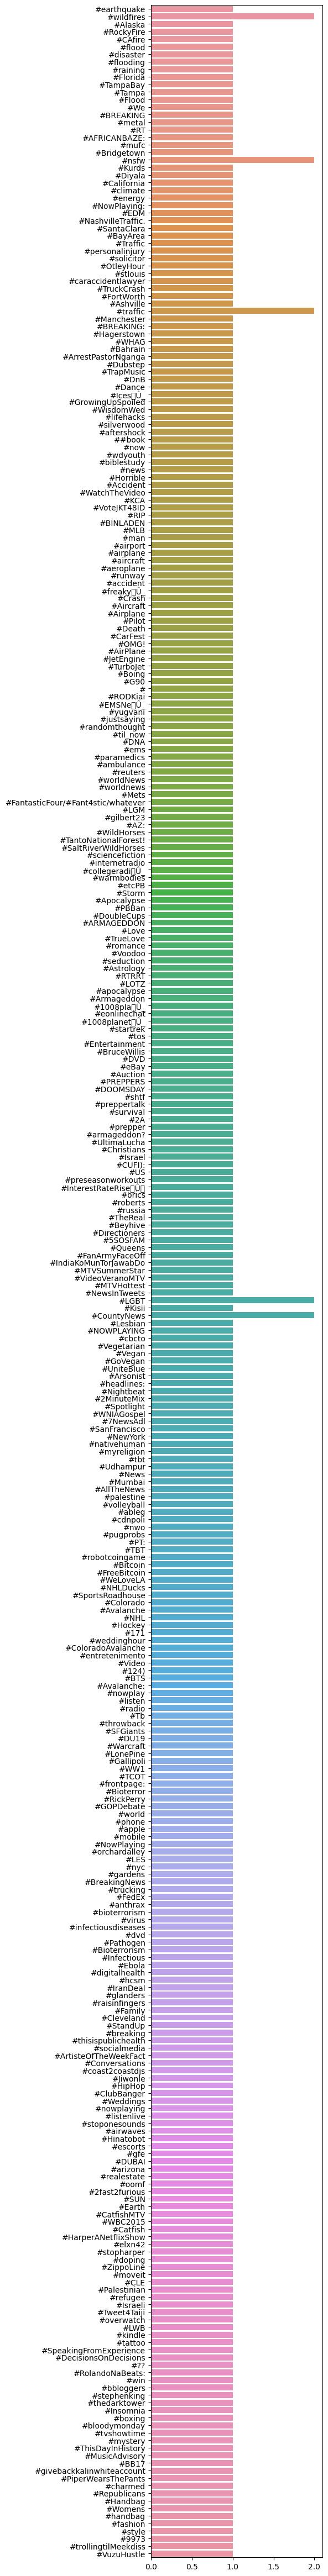

In [10]:
global hashtags_dict 
hashtags_dict = {}

def get_hashtags(text):
    ht_list = re.findall(r"(#.*?(\Z|\s))",text)
    for ht in ht_list:
        if ht[0] in hashtags_dict:
            hashtags_dict[ht[0]] = hashtags_dict[ht[0]] + 1
        else:
            hashtags_dict[ht[0].strip()] = 1
    
        
train_df['text'][:1000].apply(get_hashtags)
fig, ax = plt.subplots(figsize=(4, 60))
sns.barplot(x=list(hashtags_dict.values()),y=list(hashtags_dict.keys()),ax=ax)
plt.show()


In [11]:
[text for text in list(train_df['text'][:1000]) if '#' in text]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding',
 "#raining #flooding #Florida #TampaBay #Tampa 18 or 19 days. I've lost count ",
 '#Flood in Bago Myanmar #We arrived Bago',
 'Damage to school bus on 80 in multi car crash #BREAKING ',
 'We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw',
 '#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi',
 "@PhDSquares #mufc they've built so much hype around new acquisition

In [12]:
accepted_encodes = [*range(32,123)]
suspicious_texts = list()
for text in list(train_df['text']):
    for c in text:
        if ord(c) not in accepted_encodes:
            suspicious_texts.append(text)
            break
suspicious_texts

['Barbados #Bridgetown JAMAICA \x89ÛÒ Two cars set ablaze: SANTA CRUZ \x89ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J',
 "on the outside you're ablaze and alive\nbut you're dead inside",
 'Man wife get six years jail for setting ablaze niece\nhttp://t.co/eV1ahOUCZA',
 'SANTA CRUZ \x89ÛÓ Head of the St Elizabeth Police Superintendent Lanford Salmon has r ... - http://t.co/vplR5Hka2u http://t.co/SxHW2TNNLf',
 'Police: Arsonist Deliberately Set Black Church In North CarolinaåÊAblaze http://t.co/pcXarbH9An',
 'Set our hearts ablaze and every city was a gift And every skyline was like a kiss upon the lips @\x89Û_ https://t.co/cYoMPZ1A0Z',
 "Progressive greetings!\n\nIn about a month students would have set their pens ablaze in The Torch Publications'... http://t.co/9FxPiXQuJt",
 '#stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 https://t.co/S2kXVM0cBA Car Accident tee\x89Û_',
 "mom: 'we didn't get home as fast as 

### Something from encoding:

\x89ÛÒ,\x89ÛÓ, \n, \x89Û_, &amp, \x89Û_,&gt,\x89ÛÏ,\x89Û,\x9d,\x89Û÷,åÊ,\x89Ûª,
\x89Û÷,å,?Ìü,å_?,\x9dmy,\n~,&lt,Ì©,å¬,ÌÑ,Ì¼

In [13]:
[text for text in train_df['text'] if "#EMSNe" in text]

['Two air ambulances on scene of serious crash between two cars and lorry in ... - http://t.co/9pFEaQeSki http://t.co/fntG70rnkx | #EMSNe\x89Û_']

# Pipeline

In [14]:
def clean_text(text):
    # p.2 typos in hastags
    text = re.sub("#RockyFire","Rocky Fire",text)
    text = re.sub("#CAfire","California Fire",text)
    text = re.sub("#RT","retwitt",text)
    text = re.sub("#AFRICANBAZE","AFRICAN BASE",text)
    text = re.sub("#mufc","Manchester United Football Club",text)
    text = re.sub("#SantaClara","Santa Clara",text)
    text = re.sub("#nsfw","porn",text)
    text = re.sub("#EDM","Electronic Dance Music",text)
    text = re.sub("#NashvilleTraffic","Nashville Traffic",text)
    text = re.sub("#OtleyHour"," ",text)
    text = re.sub("#stlouis","Sent Louis",text)
    text = re.sub("#caraccidentlawyer","car accident lawyer",text)
    text = re.sub("#TruckCrash","Truck Crash",text)
    text = re.sub("#FortWorth","Fort Worth",text)
    text = re.sub("#WHAG","WHAG",text)
    text = re.sub("#ArrestPastorNganga","Arrest Pastor Nganga",text)
    text = re.sub("#TrapMusic","trap music",text)
    text = re.sub("#GrowingUpSpoiled","growing up spoiled",text)
    text = re.sub("#WisdomWed","Wisdom wednesday",text)
    text = re.sub("#silverwood","silver wood",text)
    text = re.sub("#aftershock","after shock",text)
    text = re.sub("#WatchTheVideo","Watch the video",text)
    text = re.sub("#runway","run way",text)
    text = re.sub("#CarFest","Car festival",text)
    text = re.sub("#AirPlane","Air plane",text)
    text = re.sub("#JetEngine","jet engine",text)
    text = re.sub("#OMG","oh my God",text)
    text = re.sub("#Aircraft","aircraft",text)
    text = re.sub("#EMSNe"," ",text)
    
    
    # p.1 deleting hashtags
    text = re.sub("#","",text)
    
    # p.6 links
    text = re.sub(r"http(s)?:.*?(\Z|\s)","",text)
    
    # p.7 replacing unsual encodes
    text = re.sub("\x89ÛÒ"," ",text)
    text = re.sub("\x89ÛÓ"," ",text)
    text = re.sub("\n~"," ",text)
    text = re.sub("\n"," ",text)
    text = re.sub("\x89Û_"," ",text)
    text = re.sub("&amp"," ",text)
    text = re.sub("&gt"," ",text)
    text = re.sub("\x89ÛÏ"," ",text)
    text = re.sub("\x9d"," ",text)
    text = re.sub("\x89Û÷"," ",text)
    text = re.sub("\x89Û"," ",text)
    text = re.sub("åÊ"," ",text)
    text = re.sub("\?Ìü"," ",text)
    text = re.sub("å_?"," ",text)
    text = re.sub("\x9dmy"," ",text)
    text = re.sub("&lt"," ",text)
    text = re.sub("Ì©"," ",text)
    text = re.sub("å¬"," ",text)
    text = re.sub("å"," ",text)
    text = re.sub("ÌÑ"," ",text)
    text = re.sub("Ì¼"," ",text)
    
    # p.3 gramma corrector
    spell = SpellChecker()
    new_text = ' '
    for word in text.split():
        temp_word = spell.correction(word)
        if temp_word != None:
            new_text= new_text + ' ' + temp_word
        else:
            new_text= new_text + ' ' + word
    new_text = new_text.lstrip()
    
    # p.4 abbreviations
    text = re.sub("bb","bye bye",new_text)
    text = re.sub("nsfw","no satisfy for working",new_text)
    text = re.sub("MRW","My reaction when",new_text)
    
    # p.5 smiles
    text = re.sub(":\)","smile emoji",new_text)
    text = re.sub(":D","big smile emoji",new_text)

    return new_text

In [26]:
combine = [train_df[:2500],test_df]

In [27]:
train_df[:2500].groupby('target').count()

,id,keyword,location,text
target,,,,
0,1525,1509,1010,1525
1,975,960,682,975


In [ ]:
from tqdm import tqdm
tqdm.pandas()

for df in combine:
    df['text'] = df['text'].progress_apply(clean_text)

 16%|████████████▊                                                                  | 404/2500 [02:10<13:42,  2.55it/s]

# Training

In [ ]:
class InputSample():
        def __init__(self,choices_features,label):
            input_ids, input_mask, segment_ids = choices_features
            self.input_ids = input_ids
            self.input_mask = input_mask
            self.segment_ids = segment_ids
            self.label = label  

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
def text_to_train_test_feautures(examples,labels,max_len):
    feautures_X = []
    feautures_Y = []
    feautures_train = []
    feautures_test = []   
    
    for i,example in enumerate(examples):
        text = tokenizer.tokenize(example)

        tokens = ["[CLS]"] + text + ["[SEP]"]  
        segment_ids = [0] * (len(text) + 2) 
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)

        padding_length = max_len - len(input_ids)
        input_ids += ([0] * padding_length)
        input_mask += ([0] * padding_length)
        segment_ids += ([0] * padding_length)
        
        feautures_X.append([input_ids, input_mask, segment_ids])
        feautures_Y.append(labels[i])
        
    skf = StratifiedKFold(n_splits=2)
    for train_index, test_index in skf.split(feautures_X, feautures_Y):
        X_train, X_test = np.array(feautures_X)[train_index.astype(int)], np.array(feautures_X)[test_index.astype(int)]
        y_train, y_test = np.array(feautures_Y)[train_index.astype(int)], np.array(feautures_Y)[test_index.astype(int)]
   
        
    for train_sample_X,train_sample_Y in zip(X_train,y_train):
        feautures_train.append(InputSample(
            choices_features = (train_sample_X[0],train_sample_X[1],
                               train_sample_X[2]),
            label = train_sample_Y
        ))
    
    for test_sample_X,test_sample_Y in zip(X_train,y_train):
        feautures_test.append(InputSample(
            choices_features = (test_sample_X[0],test_sample_X[1],
                               test_sample_X[2]),
            label = test_sample_Y
        ))
    
    return feautures_train, feautures_test

def text_to_feautures(examples,max_len):
    feautures = {}
    
    for i,example in enumerate(examples):
        text = tokenizer.tokenize(example)

        tokens = ["[CLS]"] + text + ["[SEP]"]  
        segment_ids = [0] * (len(text) + 2) 
        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1] * len(input_ids)

        padding_length = max_len - len(input_ids)
        input_ids += ([0] * padding_length)
        input_mask += ([0] * padding_length)
        segment_ids += ([0] * padding_length)

        if 'input_ids' not in feautures:
            feautures['input_ids'] = [torch.tensor(input_ids)]
        else:
            feautures['input_ids'].append(torch.tensor(input_ids))
            
        if 'input_mask' not in feautures:
            feautures['input_mask'] = [torch.tensor(input_mask)]
        else:
            feautures['input_mask'].append(torch.tensor(input_mask))
            
        if 'segment_ids' not in feautures:
            feautures['segment_ids'] = [torch.tensor(segment_ids)]
        else:
            feautures['segment_ids'].append(torch.tensor(segment_ids))

    
    return feautures

In [ ]:
class DisasterDataset(Dataset):
    def __init__(self,data,pass_labels=True):
        self.samples = data
        self.len = len(self.samples)
        
    def __len__(self):
        return self.len
        
    def __getitem__(self,index):
        items = {"input_ids": torch.tensor(self.samples[index].input_ids),
                "input_mask": torch.tensor(self.samples[index].input_mask),
                "segment_ids": torch.tensor(self.samples[index].segment_ids),
                "label": torch.tensor(self.samples[index].label)}
        return items

class NerualNet(nn.Module):
    def __init__(self, hidden_size=768, num_class=1):
        super(NerualNet, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
                param.requires_grad = True
        self.fc = nn.Linear(hidden_size, num_class)
        self.sigm = nn.Sigmoid()
        
    def forward(self,input_ids,input_mask,segment_ids):
        bert_output = self.bert(input_ids, token_type_ids=segment_ids, attention_mask=input_mask)
        output = self.fc(bert_output[1].squeeze())
        y_pred = self.sigm(output).squeeze()
        return y_pred
        

In [ ]:
class Trainer():
    def __init__(self,num_epochs=None,batch_size=None,
                 max_batches_per_epoch=None,early_stopping=10,
                 loss_fn=None,optimizer=None,model=None,
                 scheduler=None,device='cpu'):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.early_stopping = early_stopping
        self.loss_fn = loss_fn
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.start_model = model
        self.best_model = model

        self.train_loss = []
        self.valid_loss = []
        
    def predict(self, input_ids,input_mask,segment_ids):
        return self.best_model(input_ids,input_mask,segment_ids)
        
    def fit(self, train_dataset,valid_dataset):
        device = torch.device(self.device)
        
        NerualNet = self.start_model
        NerualNet.to(device)
        
        NerualNet.train()
        
        self.optimizer = optim.Adam(NerualNet.parameters(), lr=0.0001)
        
        train_loader = DataLoader(dataset=train_dataset, batch_size=self.batch_size, 
                                           shuffle=False,drop_last=True)
        valid_loader = DataLoader(dataset=valid_dataset, batch_size=self.batch_size, 
                                           shuffle=False,drop_last=True)
        
        best_val_loss = float('inf') # Лучшее значение функции потерь на валидационной выборке
                                     
        best_ep = 0                  # Эпоха, на которой достигалось лучшее 
                                     # значение функции потерь на валидационной выборке
        
        for epoch in range(self.num_epochs):
            start = dt.datetime.now()
            mean_loss = 0
            batch_n = 0
            for batch in train_loader:
                y_truth = batch["label"].float().to(device)
                input_ids = batch["input_ids"].to(device)
                input_mask = batch["input_mask"].to(device)
                segment_ids = batch["segment_ids"].to(device)
                
                y_pred = NerualNet(input_ids, input_mask,segment_ids).float()
                loss = self.loss_fn(y_pred, y_truth)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n     
            self.train_loss.append(mean_loss)
            print(f'Эпоха: {epoch + 1}\n Train loss: {mean_loss}\n {dt.datetime.now() - start} сек.\n')

            NerualNet.eval()
            mean_loss = 0
            batch_n = 0
            with torch.no_grad():
                for batch in valid_loader:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break

                input_ids = batch["input_ids"].to(device)
                input_mask = batch["input_mask"].to(device)
                segment_ids = batch["segment_ids"].to(device)
                target = batch["label"].float().to(device)


                predicted_values = NerualNet(input_ids, input_mask,segment_ids).float()
                loss = self.loss_fn(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1

            mean_loss /= batch_n
            self.valid_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = NerualNet
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()
            
            
        print("-=-=-=-=-=-=-=-=-=-= Evaluation of the best model =-=-=-=-=-=-=-=-=-=-")    
        plt.plot(range(len(self.train_loss)), self.train_loss, color='green', label='train', linestyle='solid')
        plt.plot(range(len(self.valid_loss)), self.valid_loss, color='red', label='val',linestyle='solid')
        plt.legend()
        plt.show()
        
        y_test = [float(sample['label']) for sample in valid_dataset]
        Y_pred = []
        Y_pred = [self.best_model(sample['input_ids'].unsqueeze(0).to(device), sample['input_mask'].unsqueeze(0).to(device),sample['segment_ids'].unsqueeze(0).to(device)) for sample in valid_dataset]
        Y_pred = [float(y > 0.5) for y in Y_pred]
        print()
        
        print(f"report: \n",classification_report(y_test,Y_pred))
        

In [ ]:
torch.cuda.empty_cache()

In [ ]:
max_len = train_df.text.str.len().max()
train_feautures, valid_feautures = text_to_train_test_feautures(train_df['text'],
                                                    train_df['target'],max_len)

train_dataset = DisasterDataset(train_feautures)
valid_dataset = DisasterDataset(valid_feautures) 



trainer = Trainer(num_epochs=40,batch_size=8,loss_fn=nn.BCELoss(),
                  model=NerualNet(),device='cuda:0')

trainer.fit(train_dataset=train_dataset,valid_dataset=valid_dataset)
        

In [ ]:
PATH = "bert-base-uncased"
torch.save(trainer.best_model.state_dict(),PATH)

In [ ]:
max_len = test_df.text.str.len().max()
feautures = text_to_feautures(test_df['text'],max_len)
device = "cuda:0"

Y_pred = []
for sample_num in range(len(feautures['input_ids'])):
    Y_pred.append(trainer.predict(feautures['input_ids'][sample_num].unsqueeze(0).to(device),
                                           feautures['input_mask'][sample_num].unsqueeze(0).to(device),
                                           feautures['segment_ids'][sample_num].unsqueeze(0).to(device)))


In [ ]:
Y_pred = [int(y > 0.5) for y in Y_pred]

In [ ]:
submission_df = pd.DataFrame({'id':test_df['id'], 'target':Y_pred})

In [86]:
submission_df.to_csv('submission.csv', index=False)